In [15]:
import torch
import pandas as pd
from safetensors.torch import safe_open

In [16]:
acts = {}
with safe_open("./data/tasks/face_task2k.safetensors", framework="pt") as f:
    for k in f.keys():
        acts[k] = f.get_tensor(k)

In [17]:
task = pd.read_parquet("./data/tasks/face_task2k_with_labels.parquet")
task

data  positive  label
0               celeba/398.jpg      True    585
1              celeba/3833.jpg      True    906
2              celeba/4836.jpg      True    903
3              celeba/4572.jpg      True    459
4               celeba/636.jpg      True    903
...                        ...       ...    ...
1995  val2017/000000294855.jpg     False    764
1996  val2017/000000142790.jpg     False    802
1997  val2017/000000297085.jpg     False    851
1998  val2017/000000140286.jpg     False    603
1999  val2017/000000125211.jpg     False    340

[2000 rows x 3 columns]

In [18]:
def subtract_control(task: pd.DataFrame, acts: dict[str, torch.Tensor]):
	task_idxs = task[task["positive"] == True].index.values
	control_idxs = task[task["positive"] == False].index.values 
	controlled = {}
	for l in acts:
		tensor = acts[l]
		task_tensor = tensor[task_idxs]
		control_tensor = tensor[control_idxs]
		controlled[l] = torch.mean(task_tensor - control_tensor, dim=0)
	return controlled
		

c = subtract_control(task, acts)

In [19]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

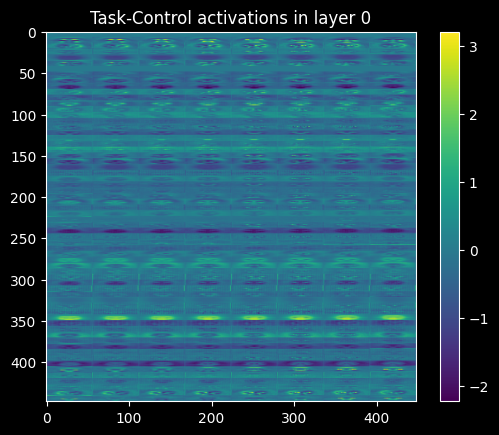

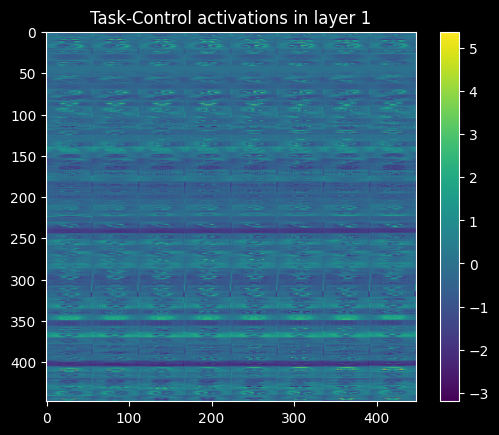

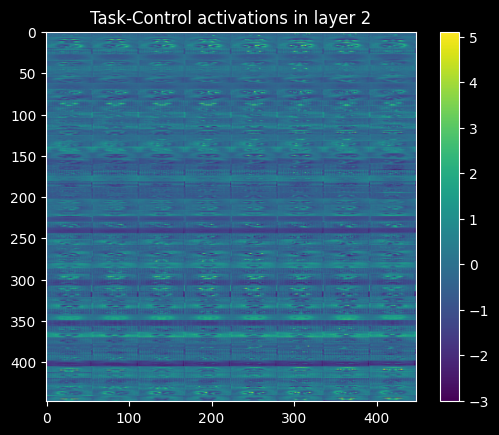

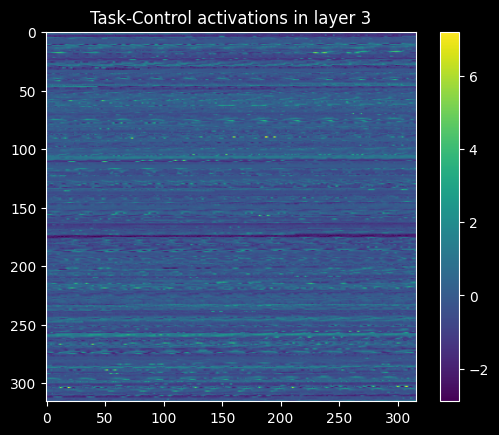

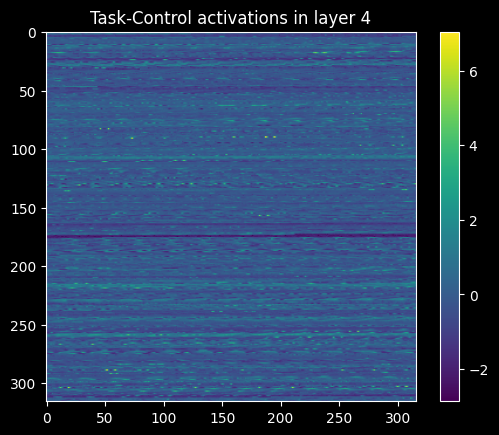

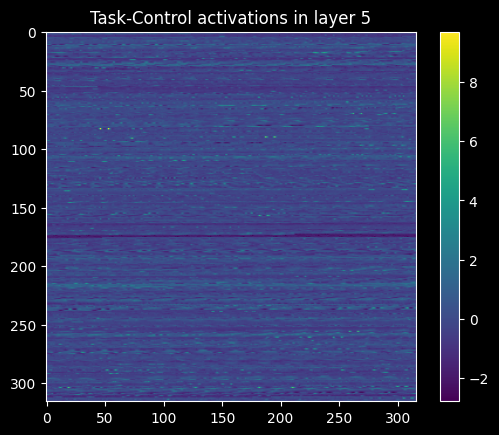

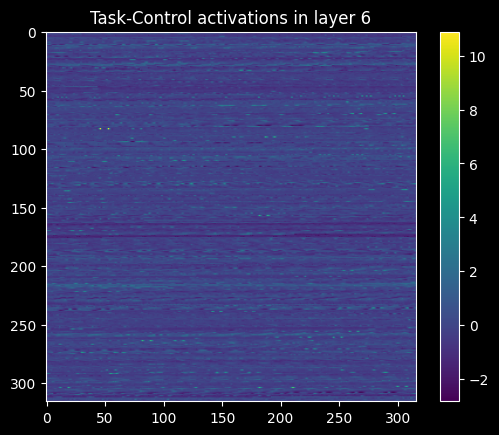

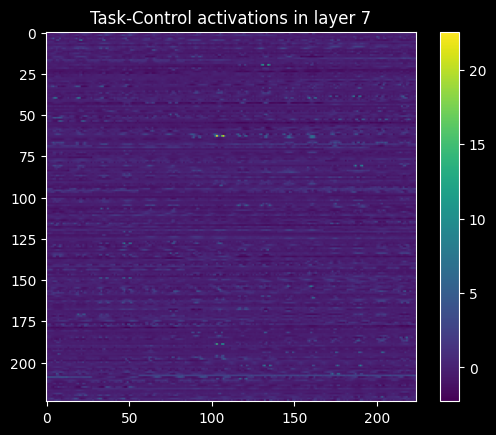

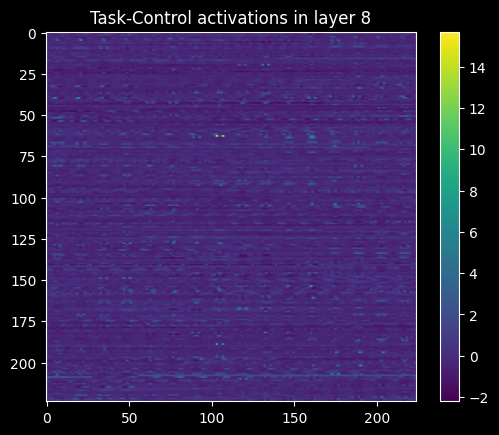

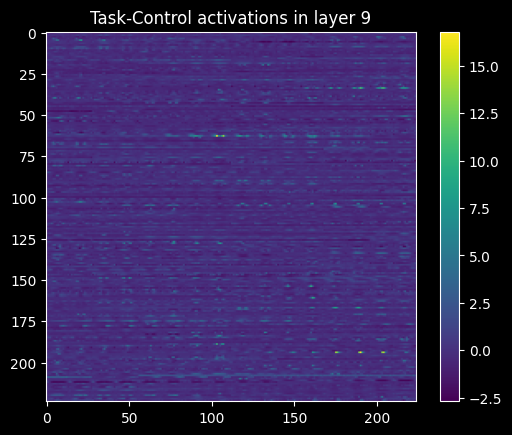

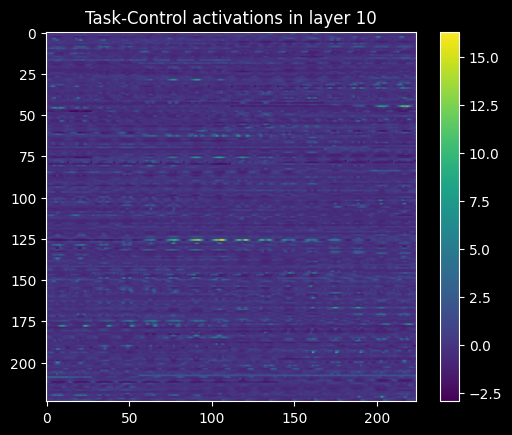

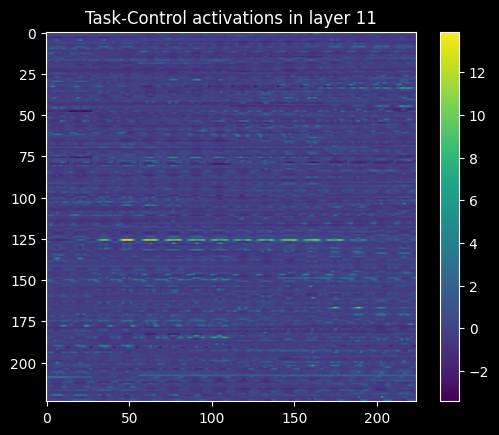

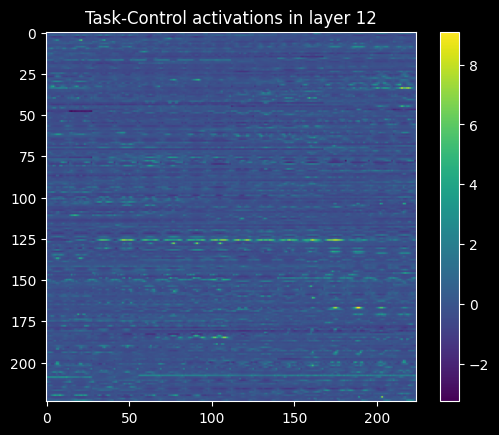

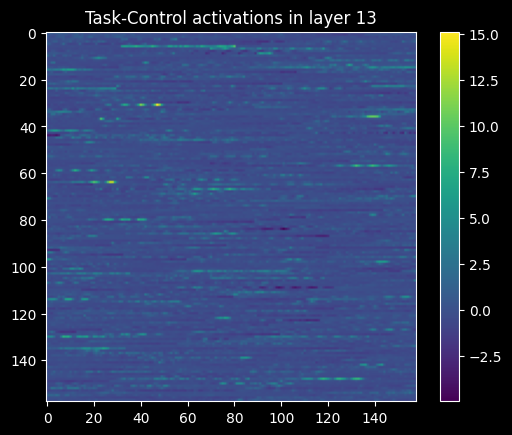

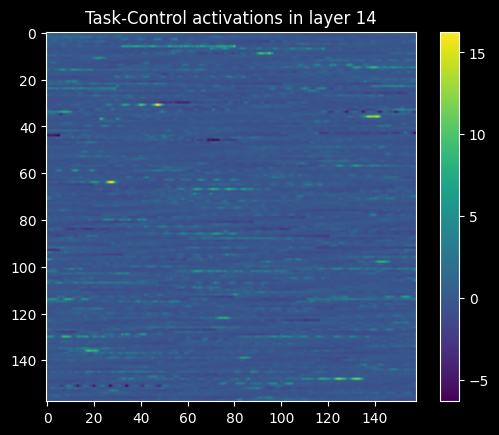

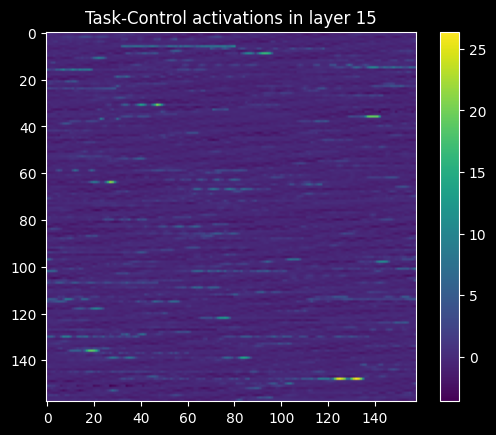

In [20]:
def map_flat(tensor_dict):
    return torch.hstack([tensor_dict[l].flatten() for l in tensor_dict])

def prod(l):
    p=1
    for i in l: p*=i
    return p

# first combine all the layers so can do argpartition
for l in range(16):
    t = c[f"layer{l}"]
    d = int(prod(t.shape)**(0.5))
    plt.title(f"Task-Control activations in layer {l}")
    plt.imshow(t.flatten()[:d*d].reshape((d, d)))
    plt.colorbar()
    plt.show()

Now let's just look at overall magnitude

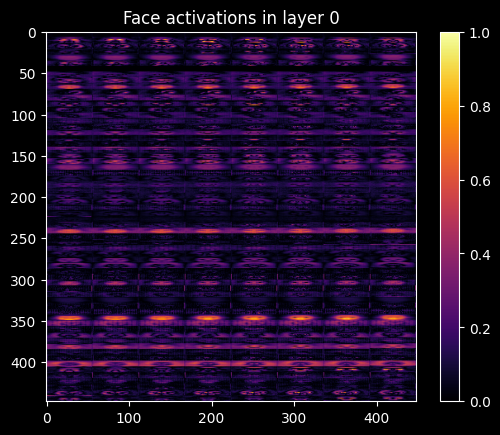

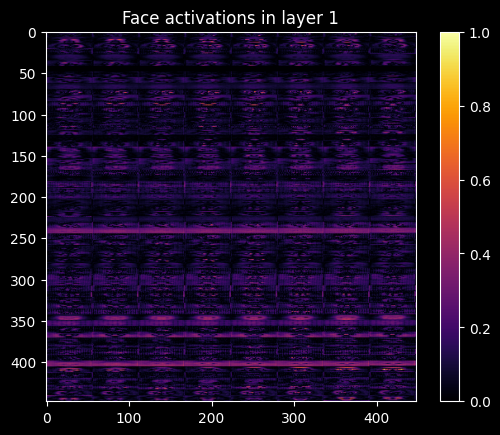

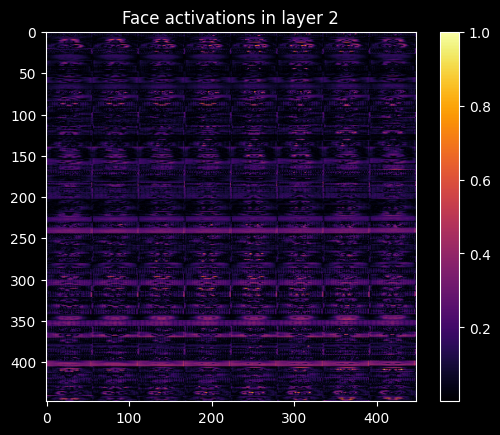

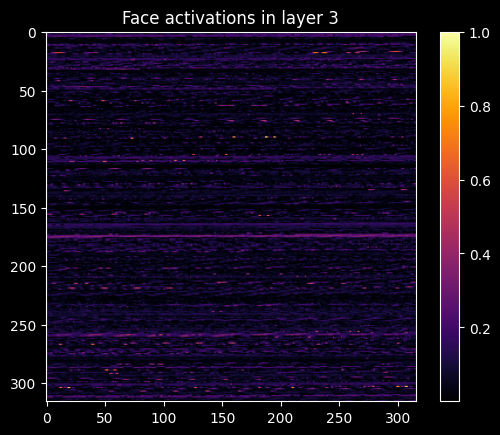

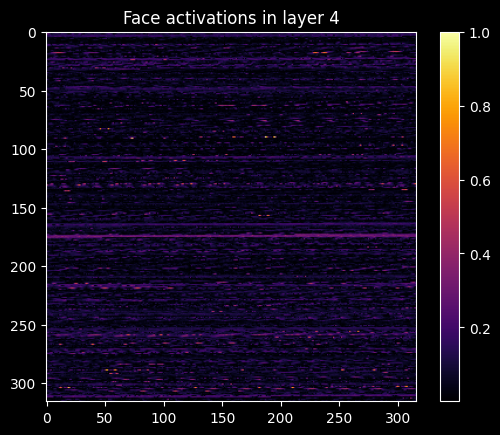

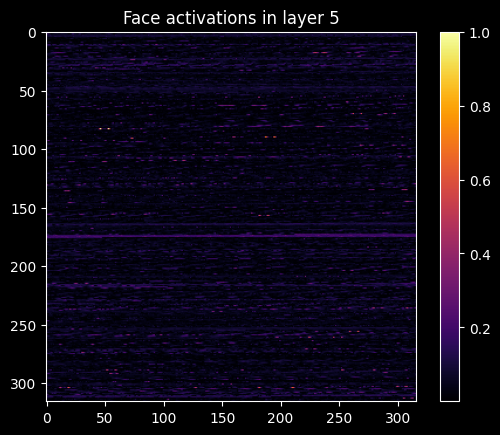

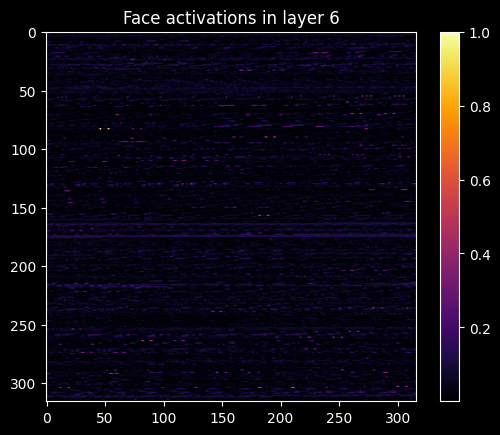

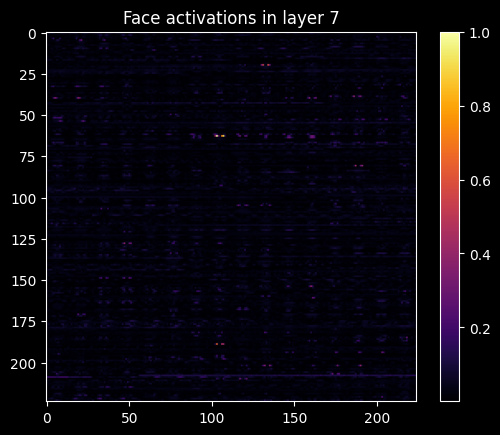

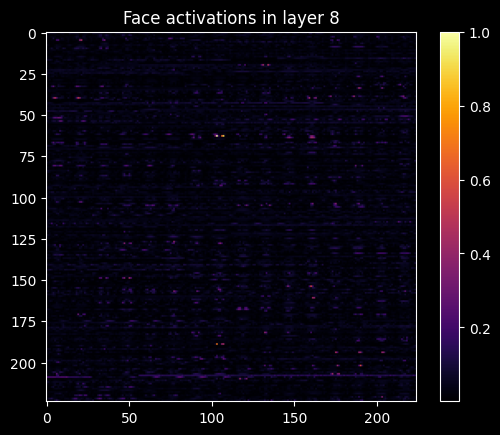

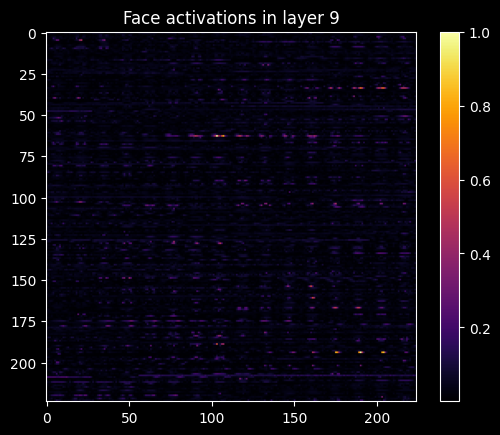

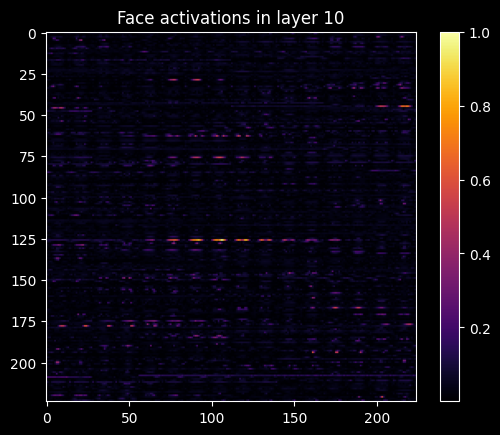

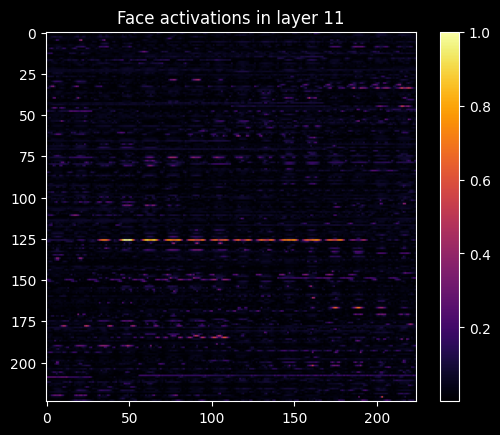

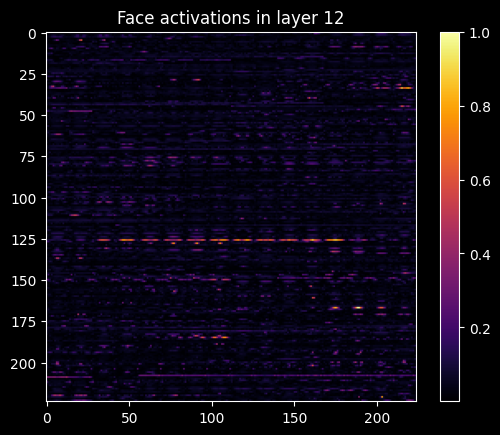

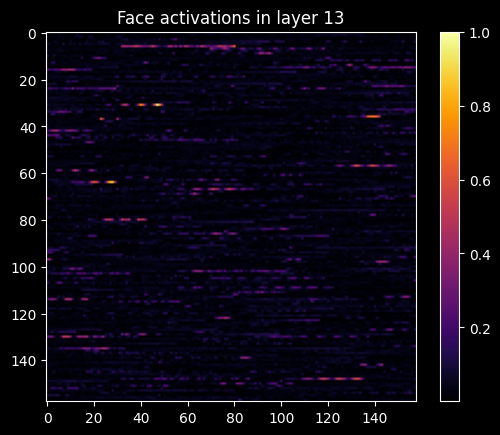

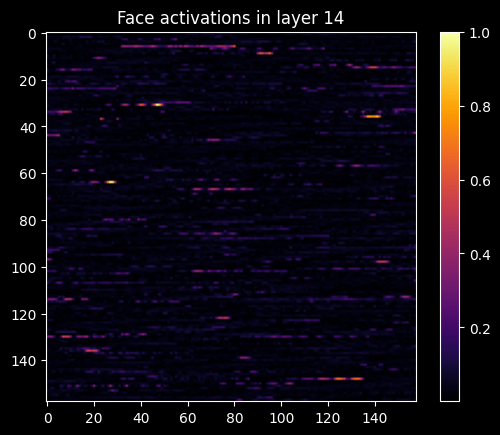

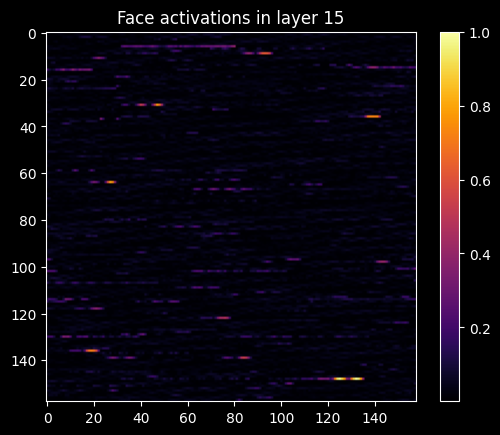

In [21]:
def normalize(v: torch.Tensor):
    return v / v.max()

# first combine all the layers so can do argpartition
for l in range(16):
    t = c[f"layer{l}"]
    d = int(prod(t.shape)**(0.5))
    plt.title(f"Face activations in layer {l}")
    plt.imshow(normalize(t).abs().flatten()[:d*d].reshape((d, d)), cmap="inferno")
    plt.colorbar()
    plt.show()

In [22]:
out = c["layer0"].flatten().topk(k=20)
print(out.indices)
print(out.values)

tensor([  4569,   4568,   4570, 156265, 156266, 156270,   5567, 156269, 183603,
        156267, 156264, 156268,   4558,   4559, 156209, 156271, 183662, 156321,
        156326, 156214])
tensor([3.2068, 3.1725, 2.9760, 2.8962, 2.8828, 2.8822, 2.8462, 2.8397, 2.8296,
        2.8138, 2.7998, 2.7983, 2.7941, 2.7801, 2.7729, 2.7703, 2.7690, 2.7392,
        2.7384, 2.7350])


In [34]:
def top_percent_per_layer(layer, percent):
    topk = int((percent/100)*prod(layer.shape))
    return layer.flatten().topk(k=topk)

top_percent = 0.5
for l in range(16):
    t = c[f"layer{l}"].abs()
    _, idxs = top_percent_per_layer(t,top_percent)
    print(len(idxs))

1003
1003
1003
501
501
501
501
250
250
250
250
250
250
125
125
125


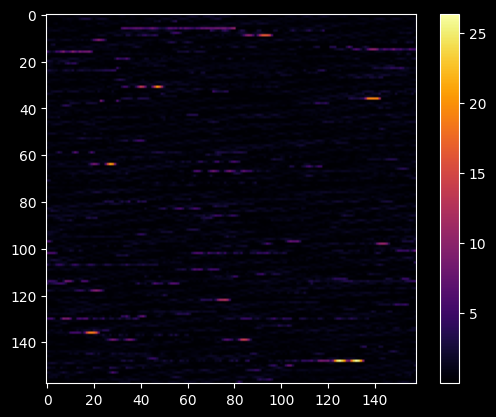

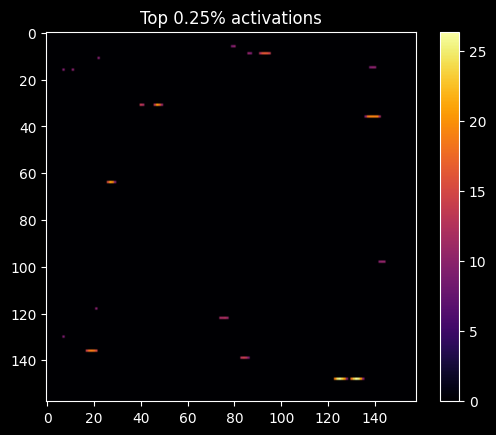

In [33]:
l = c["layer15"]
canvas = torch.zeros(l.shape)
top_percent = 0.25
act, idxs = top_percent_per_layer(l.abs(), top_percent)

canvas.view(-1)[idxs] = act

def squarify(t):
	d = int(prod(t.shape)**(0.5))
	return t.flatten()[:d*d].reshape((d,d))

plt.imshow(squarify(l.abs()), cmap="inferno")
plt.colorbar()
plt.show()
plt.title(f"Top {top_percent}% activations")
plt.imshow(squarify(canvas), cmap="inferno")
plt.colorbar()